#**Downloading Data & Libraries**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [00:24<00:00, 98.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [ ]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 61.6 MB/s eta 0:00:00


#**Importing Libraries**

In [ ]:
import time
import os
import copy

#pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

#Pennylane
import pennylane as qml
from pennylane import numpy as np

#plotting
import matplotlib.pyplot as plt

os.environ["OMP_NUM_THREADS"] = "1"

#**Initializing Hyperparameters**

In [ ]:
n_qubit = 4                 #Number of Qubits
step = 0.0004               #Learning rate
batch_size = 4              #Number of samples for each training step
num_epochs = 3              #Number of training epoch
q_depth = 6                 #Depth of the quantum circuit (No.of Variational layers)
gamma_lr_scheduler = 0.1    #Learning rate reduction applied every 10 epochs
q_delta = 0.01              #Initial spread of random quantum weights
start_time = time.time()    #Start of Computational timer

#**Device Setup**

In [ ]:
#Setting up the device on which the neural network is to be trained.
#Here we use only CPU.
#Also setting up the device for Quantum Node in Pennylane QML.

dev = qml.device("default.qubit", wires=n_qubit)
device = torch.device("cpu")

#**Resize Image Function**

In [ ]:
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor()
    ]),

    "val": transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor()
    ])
}

#**Importing Dataset**

In [ ]:
data_dir = os.path.join(path, "chest_xray")
image_datasets = {
    x if x == "train" else "validation":datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}

In [ ]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 5216
     Root location: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 'validation': Dataset ImageFolder
     Number of datapoints: 16
     Root location: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            )}

#**Get Class names:**

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes
print(class_names)

['NORMAL', 'PNEUMONIA']


#**Loading Dataset**

* The ```torch.utils.data.DataLoader``` class is used in the ```PyTorch``` library to create a Python iterable over a dataset.

* It provides features such as **batching, shuffling, and parallel loading of data,** making it convenient for training and evaluating models with large datasets.

In [ ]:
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=batch_size, shuffle=True
    )
    for x in ["train", "validation"]
}

In [ ]:
dataloaders['train']

In [ ]:
dataloaders['validation']

#**Display Tensor Image**

* ```input.numpy()``` converts the PyTorch tensor to a NumPy array.

* ```.transpose(1, 2, 0)``` rearranges the dimensions from (C, H, W) (Channels, Height, Width) to (H, W, C), which is the format expected by Matplotlib.

* ```np.clip(inp, 0, 1)``` ensures all pixel values are within the valid range [0, 1].

In [ ]:
def image_show(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)


* ```dataloaders["validation"]``` is a DataLoader object that provides batches of validation data.

* ```next(iter(...))``` fetches the next batch from the DataLoader.

* ```inputs``` contains the image tensors, and ```classes``` contains their corresponding labels.

* ```torchvision.utils.make_grid``` creates a grid of images from the batch inputs, arranging them into a single image.

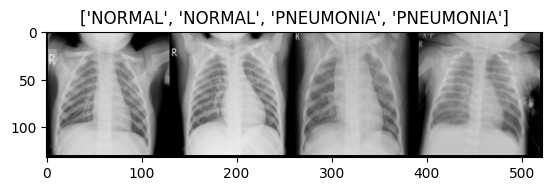

In [ ]:
inputs, classes = next(iter(dataloaders['validation']))
#Make a grid from batch
out = torchvision.utils.make_grid(inputs)
image_show(out, title=[class_names[x] for x in classes])

#**Creating Quantum Variational Circuit**

* **H-Layer**:
  * **Define:** The Hadamard gate creates superposition. It maps the states ``` ∣0⟩ and ∣1⟩``` to ```∣+⟩=(∣0⟩+∣1⟩)/√2 ``` and ```∣−⟩=(∣0⟩−∣1⟩)/√2```, respectively.

  * **Use Case:** Often used as an initial step in quantum algorithms to prepare qubits in superposition states.

* **RY-Layer**:
  * **Define:** The ```RY​(θ)``` gate rotates the qubit state around the
  𝑦 axis of the Bloch sphere by an angle 𝜃.

  * **Use Case:** Adds parametric rotation to qubits, which is essential for implementing variational quantum circuits or training quantum models.

* **Entangling Layer - CNOT Gate:**
  * **Define:** The controlled-NOT gate flips the target qubit ```(𝑖+1)``` if the control qubit
  ```(𝑖)``` is in the ```∣1⟩ ``` state.

  * **Use Case:** Introduces correlations (entanglement) among qubits, a key feature of quantum algorithms and quantum neural networks.

In [ ]:
#Hadamard Gate
def H_layer(nqubits):
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

#Ry - Rotational Gate
def RY_layer(w):
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

#Layer of CNOTs followed by shifted layer of CNOTs
# CNOT    CNOT    CNOT    CNOT ...   CNOT
#     CNOT    CNOT    CNOT    CNOT ...   CNOT
def entangling_layer(nqubits):
  for i in range(0, nqubits - 1, 2):
    qml.CNOT(wires=[i, i + 1])
  for i in range(1, nqubits - 1, 2):
    qml.CNOT(wires=[i, i + 1])

* **QNode Decorator - ```@qml.qnode```:**
  * This decorator specifies that the function ```quantum_net``` represents a quantum circuit. The ```dev``` argument is a quantum device.

* **`q_input_features:`**
  * Input features, a vector, used to encode classical data into the quantum circuit, typically using parameterized gates (like RY in this case).

* **`q_weights_flat:`**
  * A flattened list or array of trainable quantum circuit parameters (weights).

* **`exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubit)]`:**
  * Measure the expectation values of the Pauli-Z operator for each qubit.

  * The expectation value for the Pauli-Z operator represents the likelihood of measuring a qubit in the `∣0⟩` or `∣1⟩` state.



In [ ]:
from math import exp
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
  q_weights = q_weights_flat.reshape(q_depth, n_qubit)
  H_layer(n_qubit)
  RY_layer(q_input_features)

  for k in range(q_depth):
    entangling_layer(n_qubit)
    RY_layer(q_weights[k])

  exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubit)]
  return tuple(exp_vals)

#Defining Dressed Quantum Circuit

* **`pre_net (Linear layer):`**
  * **Define:** This is a classical linear layer that maps input features of size 512 to a smaller size n_qubit.

  * **Use:** This is used to reduce the dimensionality and prepare the data for input to the quantum part of the network.

* **`q_params (Quantum parameters):`** These are trainable parameters (nn.Parameter) representing the parameters of the quantum circuit. The tensor `q_delta * torch.randn(q_depth * n_qubit)` initializes them with random values scaled by `q_delta`. Here:

  * **`q_depth`:** Depth of the quantum circuit (number of layers).

  * **`n_qubit`:** Number of qubits in the quantum system.

* **`post_net (Linear layer):`** Another classical linear layer maps the output of the quantum circuit (n_qubit outputs) to a final output of size 2. This could represent two classes if the model is for classification.

* **`torch.tanh(pre_out)`**: ensures the output values are in the range [-1, 1].

* The output is scaled by `π/2` to ensure compatibility with the quantum circuit (angle encoding).

* **`quantum_net(elem, self.q_params)`:**
  * Encodes `elem` (a single input vector) into the quantum circuit.

  * Applies quantum operations parameterized by `self.q_params`.
  
  * Returns the output of the quantum circuit.


In [ ]:
class DressedQuantumNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pre_net = nn.Linear(512, n_qubit)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubit))
        self.post_net = nn.Linear(n_qubit, 2)

    def forward(self, input_features):
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        q_out = torch.Tensor(0, n_qubit)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        return self.post_net(q_out)

#Build the Classical-Quantum Network:

##**ResNet:**


**Hybrid Neural Network:**
The following code snippet modifies a pre-trained `ResNet-18` model to create a hybrid classical-quantum neural network by replacing its final fully connected (FC) layer with the previously defined **`DressedQuantumNet`**.

In [ ]:
weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
model_hybrid = torchvision.models.resnet18(weights=weights)

for param in model_hybrid.parameters():
    param.requires_grad = False

model_hybrid.fc = DressedQuantumNet()
model_hybrid = model_hybrid.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


**Setting up the Loss function and Optimizer:**

* **`criterion = nn.CrossEntropyLoss()`**: Computes the loss for multi-class classification problems.

* **`optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)
`**:




In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0

    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0

            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Batch: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                    )
                it+=1

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f} Time: {:.4f}".format(
                    phase,
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                    time.time() - since,
                )
            )

            # deep copy the model for best model
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss

            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc

            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            if phase == "train":
                scheduler.step()

    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since

    print("Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print(f"Best val Acc: {best_acc:4f}")
    print(f"Best val Loss: {best_loss:4f}")
    print(f"Best train Acc: {best_acc_train:4f}")
    print(f"Best train Loss: {best_loss_train:4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Train the Model:
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

Training started:
Phase: train Epoch: 1/3 Loss: 0.3786 Acc: 0.8564 Time: 487.7849
Phase: validation Epoch: 1/3 Loss: 0.4460 Acc: 0.8125 Time: 488.7111
Phase: train Epoch: 2/3 Loss: 0.3099 Acc: 0.8848 Time: 954.8954
Phase: validation Epoch: 2/3 Loss: 0.4522 Acc: 0.8750 Time: 955.8495
Phase: train Epoch: 3/3 Loss: 0.2997 Acc: 0.8886 Time: 1459.1422
Phase: validation Epoch: 3/3 Loss: 0.4989 Acc: 0.6875 Time: 1460.0698
Training completed in 24m 20s
Best val Acc: 0.875000
Best val Loss: 0.446048
Best train Acc: 0.888612
Best train Loss: 0.299651


In [ ]:
def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                image_show(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

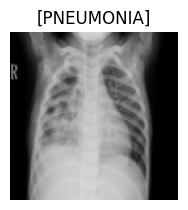

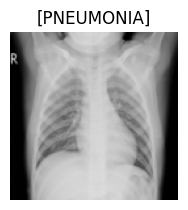

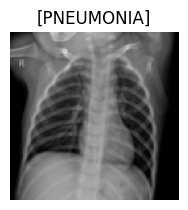

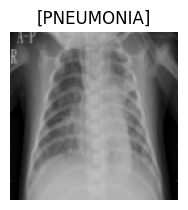

In [ ]:
visualize_model(model_hybrid, num_images=batch_size)
plt.show()

In [ ]:
def test_model():
    # Initialize counters
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    input_images = []

    # No need to track gradients for testing
    with torch.no_grad():
        # Iterate over test data
        for data in dataloaders["test"]:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Store true labels
            true_labels.extend(labels.tolist())

            #Store model input images
            input_images.append(inputs)

            # Forward pass
            outputs = model_hybrid(inputs) #Change to model_hybrid
            _, preds = torch.max(outputs.data, 1)

            # Store predicted labels
            pred_labels.extend(preds.tolist())  # Use tolist() and extend()

            # Update counters
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()

        # Calculate accuracy
        acc = running_correct / running_total

    return true_labels, pred_labels, input_images,  running_correct, running_total, acc

In [ ]:
data_transforms["test"] = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), data_transforms["test"])

In [ ]:
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loader
dataloaders["test"] = test_loader

In [ ]:
true_labels, pred_labels, input_images, running_correct, running_total, acc = test_model()

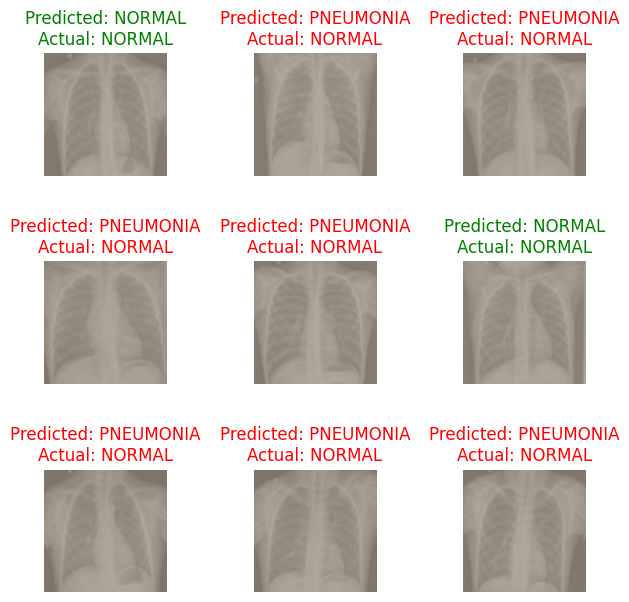

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(7, 7))
fig.subplots_adjust(hspace=0.7, wspace=0.7)
x=0
for i in range(3):
    for j in range(3):
        # Get the image and labels
        # Accessing the image from the batch
        inp = input_images[x // batch_size][x % batch_size]

        true_label = true_labels[x]
        pred_label = pred_labels[x]

        # Normalize the image for display
        inp = inp.cpu().numpy().transpose((1, 2, 0)) # Now inp should be 3D
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

        # Display the image
        axes[i, j].imshow(inp)

        # Set the title with the predicted and actual labels
        title = "Predicted: {}\nActual: {}".format(class_names[pred_label], class_names[true_label])
        color = 'green' if pred_label == true_label else 'red'
        axes[i, j].set_title(title, color=color)

        # Hide the axes
        axes[i, j].axis('off')

        # Move to the next image
        x += 1

plt.show()

In [ ]:
print("Total Correct: {} \nTotal Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)

Total Correct: 474.0 
Total Test Images: 624.0
Test Accuracy:  0.7596153846153846


##**EfficientNet:**

In [ ]:
from torchvision.models import efficientnet_b0
effi_base_model = efficientnet_b0(pretrained=True)
for param in effi_base_model.parameters():
    param.requires_grad = True

effi_base_model.fc = DressedQuantumNet()
base_model = effi_base_model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from torch.optim import AdamW

optimizer_hybrid = AdamW(model_hybrid.parameters(), lr=1e-4, weight_decay=1e-2)

In [ ]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import copy
import time

optimizer_base = optim.SGD(effi_base_model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler_base = lr_scheduler.StepLR(optimizer_base, step_size=10, gamma=0.1)

effi_model_hybrid = train_model(
    effi_base_model,
    criterion,
    optimizer_base,  # Use optimizer for base_model
    exp_lr_scheduler_base,  # Use scheduler for base_model
    num_epochs=num_epochs
)

Training started:
Phase: train Epoch: 1/3 Loss: 0.3675 Acc: 0.9057 Time: 465.4321
Phase: validation Epoch: 1/3 Loss: 0.1430 Acc: 0.9375 Time: 465.8659
Phase: train Epoch: 2/3 Loss: 0.1247 Acc: 0.9638 Time: 932.6944
Phase: validation Epoch: 2/3 Loss: 0.3033 Acc: 0.8750 Time: 933.2634
Phase: train Epoch: 3/3 Loss: 0.0734 Acc: 0.9787 Time: 1401.4703
Phase: validation Epoch: 3/3 Loss: 0.3796 Acc: 0.7500 Time: 1401.9202
Training completed in 23m 22s
Best val Acc: 0.937500
Best val Loss: 0.143010
Best train Acc: 0.978719
Best train Loss: 0.073404


In [ ]:
def test_effi_model():
    # Initialize counters
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    input_images = []

    # No need to track gradients for testing
    with torch.no_grad():
        # Iterate over test data
        for data in dataloaders["test"]:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Store true labels
            true_labels.extend(labels.tolist())

            #Store model input images
            input_images.append(inputs)

            # Forward pass
            outputs = effi_model_hybrid(inputs) #Change to model_hybrid
            _, preds = torch.max(outputs.data, 1)

            # Store predicted labels
            pred_labels.extend(preds.tolist())  # Use tolist() and extend()

            # Update counters
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()

        # Calculate accuracy
        acc = running_correct / running_total

    return true_labels, pred_labels, input_images,  running_correct, running_total, acc

In [ ]:
true_labels, pred_labels, input_images, running_correct, running_total, acc = test_effi_model()

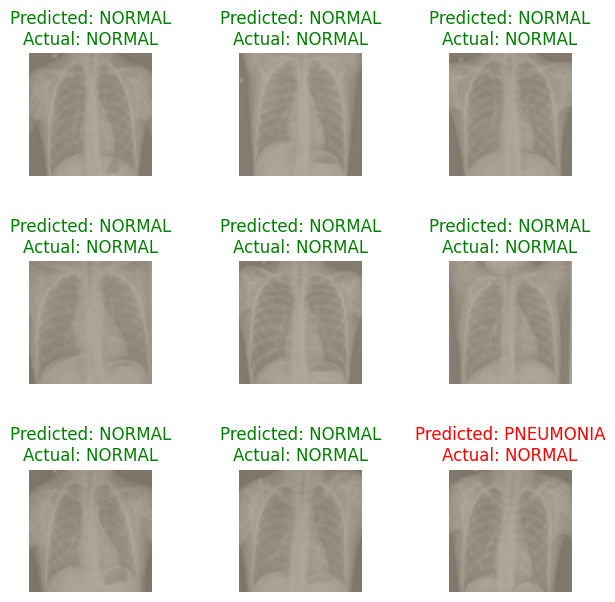

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(7, 7))
fig.subplots_adjust(hspace=0.7, wspace=0.7)
x=0
for i in range(3):
    for j in range(3):
        # Get the image and labels
        # Accessing the image from the batch
        inp = input_images[x // batch_size][x % batch_size]

        true_label = true_labels[x]
        pred_label = pred_labels[x]

        # Normalize the image for display
        inp = inp.cpu().numpy().transpose((1, 2, 0)) # Now inp should be 3D
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

        # Display the image
        axes[i, j].imshow(inp)

        # Set the title with the predicted and actual labels
        title = "Predicted: {}\nActual: {}".format(class_names[pred_label], class_names[true_label])
        color = 'green' if pred_label == true_label else 'red'
        axes[i, j].set_title(title, color=color)

        # Hide the axes
        axes[i, j].axis('off')

        # Move to the next image
        x += 1

plt.show()

In [ ]:
print("Total Correct: {} \nTotal Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)

Total Correct: 523.0 
Total Test Images: 624.0
Test Accuracy:  0.8381410256410257


##**DenseNet**

In [ ]:
from torchvision.models import densenet121
dense_model = densenet121(pretrained=True)
for param in dense_model.parameters():
    param.requires_grad = True

dense_model.fc = DressedQuantumNet()
dense_model = dense_model.to(device)

In [ ]:
from torch.optim import AdamW

optimizer_hybrid = AdamW(dense_model.parameters(), lr=1e-4, weight_decay=1e-2)


In [ ]:
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

In [ ]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import copy
import time

optimizer_base = optim.SGD(dense_model.parameters(), lr=0.001, momentum=0.9)

# Create scheduler for base_model
exp_lr_scheduler_base = lr_scheduler.StepLR(optimizer_base, step_size=10, gamma=0.1)  # Assuming gamma_lr_scheduler = 0.1


# Train the Model:
dense_hybrid_model = train_model(
    dense_model,
    criterion,
    optimizer_base,  # Use optimizer for base_model
    exp_lr_scheduler_base,  # Use scheduler for base_model
    num_epochs=num_epochs
)

In [ ]:
def dense_test_model():
    # Initialize counters
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    input_images = []

    # No need to track gradients for testing
    with torch.no_grad():
        # Iterate over test data
        for data in dataloaders["test"]:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Store true labels
            true_labels.extend(labels.tolist())

            #Store model input images
            input_images.append(inputs)

            # Forward pass
            outputs = dense_hybrid_model(inputs)
            _, preds = torch.max(outputs.data, 1)

            # Store predicted labels
            pred_labels.extend(preds.tolist())

            # Update counters
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()

        # Calculate accuracy
        acc = running_correct / running_total

    return true_labels, pred_labels, input_images,  running_correct, running_total, acc

In [ ]:
true_labels, pred_labels, input_images, running_correct, running_total, acc = dense_test_model()

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(7, 7))
fig.subplots_adjust(hspace=0.7, wspace=0.7)
x=0
for i in range(3):
    for j in range(3):
        # Get the image and labels
        # Accessing the image from the batch
        inp = input_images[x // batch_size][x % batch_size]

        true_label = true_labels[x]
        pred_label = pred_labels[x]

        # Normalize the image for display
        inp = inp.cpu().numpy().transpose((1, 2, 0)) # Now inp should be 3D
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

        # Display the image
        axes[i, j].imshow(inp)

        # Set the title with the predicted and actual labels
        title = "Predicted: {}\nActual: {}".format(class_names[pred_label], class_names[true_label])
        color = 'green' if pred_label == true_label else 'red'
        axes[i, j].set_title(title, color=color)

        # Hide the axes
        axes[i, j].axis('off')

        # Move to the next image
        x += 1

plt.show()

In [ ]:
print("Total Correct: {} \nTotal Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)